You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [101]:
men_results = pd.read_csv('men_results.csv')
men_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44353 non-null  int64 
 1   date        44353 non-null  object
 2   home_team   44353 non-null  object
 3   away_team   44353 non-null  object
 4   home_score  44353 non-null  int64 
 5   away_score  44353 non-null  int64 
 6   tournament  44353 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


In [102]:
men_results['date'] = pd.to_datetime(men_results['date']).dt.date

In [103]:
women_results = pd.read_csv('women_results.csv')
women_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4884 non-null   int64 
 1   date        4884 non-null   object
 2   home_team   4884 non-null   object
 3   away_team   4884 non-null   object
 4   home_score  4884 non-null   int64 
 5   away_score  4884 non-null   int64 
 6   tournament  4884 non-null   object
dtypes: int64(3), object(4)
memory usage: 267.2+ KB


In [104]:
women_results['date'] = pd.to_datetime(women_results['date']).dt.date

For the analysis we will use only FIFA World CUP matches cince [2002-01-01]()

In [105]:
from datetime import datetime

men_results_fifa = men_results[(men_results['tournament'] == 'FIFA World Cup')&(men_results['date']>=datetime.strptime('2002-01-01', '%Y-%m-%d').date())]
women_results_fifa = women_results[(women_results['tournament'] == 'FIFA World Cup')&(women_results['date']>=datetime.strptime('2002-01-01', '%Y-%m-%d').date())]

men_results_fifa ['total_goals'] = men_results_fifa['home_score'] + men_results_fifa['away_score']

women_results_fifa ['total_goals'] = women_results_fifa['home_score'] + women_results_fifa['away_score']

In order to choose which test to perform we need to check two underlying assumptios: 
* sample sizes are big enough
* data comes from normal distribution

In [106]:
print(len(men_results_fifa))
print(len(women_results_fifa))

384
200


Text(0.5, 1.0, 'Distribution of Total Goals in FIFA World Cup Matches (Men)')

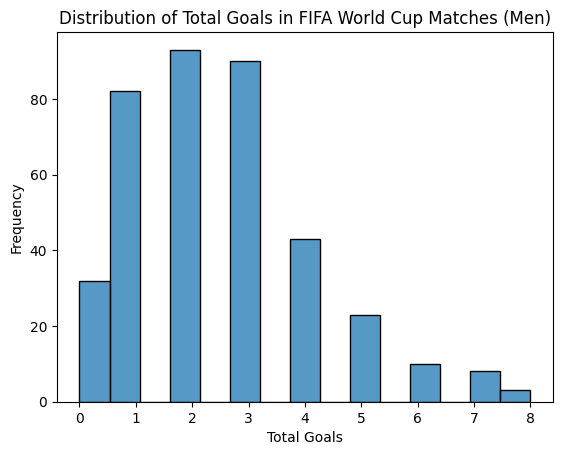

In [107]:
sns.histplot(data=men_results_fifa, x='total_goals')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.title('Distribution of Total Goals in FIFA World Cup Matches (Men)')

Text(0.5, 1.0, 'Distribution of Total Goals in FIFA World Cup Matches(Women)')

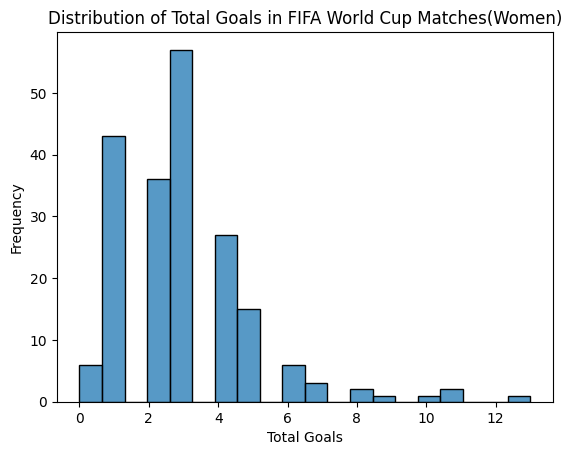

In [108]:
sns.histplot(data=women_results_fifa, x='total_goals')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.title('Distribution of Total Goals in FIFA World Cup Matches(Women)')

Data doesn't look normaly distributed. But in order to be sure we can perform Shapiro-Wilk test that tests the null hypothesis that the data was drawn from a normal distribution.

Significance level - 5%.

P-value is under 5% in both cases => We reject the null-hypothsis and the data most likely wasn't drawn from normal distribution. 

In [109]:
alpha = 0.05
print('Men:')
print(stats.shapiro(men_results_fifa['total_goals']))
print('\n Women:')
print(stats.shapiro(women_results_fifa['total_goals']))

Men:
ShapiroResult(statistic=0.9266489744186401, pvalue=8.894154401688226e-13)

 Women:
ShapiroResult(statistic=0.8491013050079346, pvalue=3.8905201759850683e-13)


Because the sample data unlikely to come from normal distribution non-parametric tests are going to be more suitable in this situation. 

To performe the hypothesis testing on two unpaired samples I'm going to use a Wilcoxon–Mann–Whitney test from _pingouin-package_

In [110]:
import pingouin

alpha = 0.1

#Data for MWU-test must be pivoted
women_df = pd.DataFrame({'total_goals': women_results_fifa['total_goals'], 'gender': 'Women'})
men_df = pd.DataFrame({'total_goals': men_results_fifa['total_goals'], 'gender': 'Men'})

combined_df = pd.concat([women_df, men_df], ignore_index=True)

pivoted_df = combined_df.pivot(columns='gender', values='total_goals')

test_results = pingouin.mwu(x=pivoted_df['Women'], y=pivoted_df['Men'], alternative='greater')

print(test_results)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107 -0.126901  0.563451


P-value is under our set significance level and therefore we reject the null hypothesis and can say that thre is a statistical evidence of that the mean number of goals scored in women's international soccer matches is greater than men's.